In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Get the dataset and prepare it for analysis and model

#### Set the index to date

In [2]:
df = pd.read_csv('USD_INR.csv')
df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)
df_idx.head(5)

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


#### Flip the dataframe

In [3]:
df_idx = df_idx.sort_index(axis=1, ascending=True)
df_idx = df_idx.iloc[::-1]

#### Plot the data

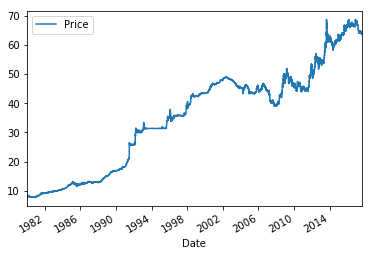

In [4]:
data = df_idx[['Price']]
data.plot(y='Price')

In [5]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1980 to %d"%(1980 + int(0.8*years)))

Total data: 37 years
80 percent data = 1980 to 2009


#### Create training and testing data

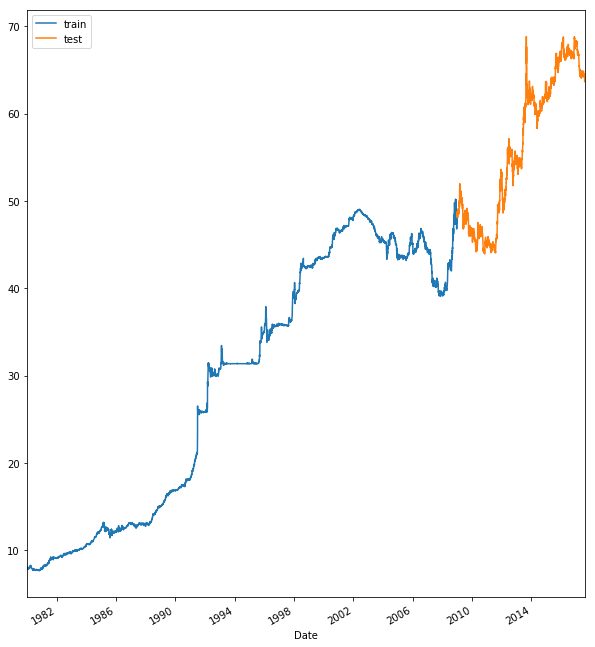

In [6]:
split_date = pd.Timestamp('01-01-2009')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

#### Normalize the dataset

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [8]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [9]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (7451 x 1)
Test size: (2245 x 1)


## Setup baseline model of SVM Regressor

In [10]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [11]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/Users/neelabhpant/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


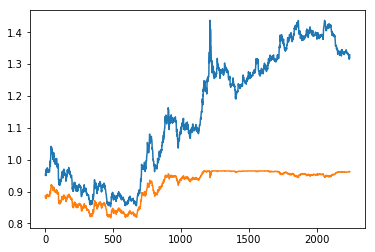

In [12]:
plt.plot(y_test)
plt.plot(y_pred)

In [13]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: -0.963381


## Build a Neural Network

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


### 1 hidden layer with 1 neuron

In [15]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
7451/7451 [==============================] - 0s - loss: 0.0025     
Epoch 2/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 3/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 4/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 5/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 6/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 7/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 8/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 9/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 10/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 11/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 12/20
7451/7451 [==============================] - 0s - loss: 0.0024     
Epoch 13/20
7451/7451 [==========================

R-Squared: -13.593283


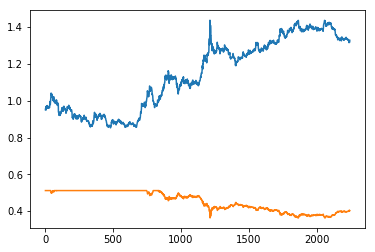

In [18]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

#### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [20]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
7451/7451 [==============================] - 1s - loss: 0.0118     
Epoch 2/20
7451/7451 [==============================] - 0s - loss: 1.4968e-05     
Epoch 3/20
7451/7451 [==============================] - 0s - loss: 9.7235e-06     
Epoch 4/20
7451/7451 [==============================] - 1s - loss: 9.0429e-06     
Epoch 5/20
7451/7451 [==============================] - 1s - loss: 1.0248e-05     
Epoch 6/20
7451/7451 [==============================] - 1s - loss: 1.0652e-05     
Epoch 7/20
7451/7451 [==============================] - 0s - loss: 1.0775e-05     
Epoch 8/20
7451/7451 [==============================] - 0s - loss: 1.1454e-05     
Epoch 9/20
7451/7451 [==============================] - 0s - loss: 1.1335e-05     
Epoch 10/20
7451/7451 [==============================] - 1s - loss: 1.1369e-05     
Epoch 11/20
7451/7451 [==============================] - 0s - loss: 1.0755e-05     
Epoch 12/20
7451/7451 [==============================] - 1s - loss: 1.1995e-05     
Epoch

R-Squared: 0.998666


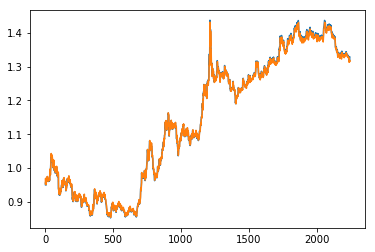

In [21]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

## Try to predict the difference between consecutive days
### This is also known as introducing stationarity in the dataset.
### A better test of the model is to predict stationarized data where the mean, standard deviation, autocorrelation are constant over time.
### Because stock price data, currency exchange etc. are generated using a completely stochastic random walk process. Being able to predict future outcomes of a stochastic process is by definition not possible, and if someone claims to do this, one should be a bit skeptical [Vegard Flovik, PhD]